# Assignment: Naïve Bayes Classifier

In this asignment you will implement Naïve Bayes classifier and the compare it to that one implemented `scikit-learn` module. The goal is to investigate the influence of Laplace correction on the classification results for Naïve Bayes classifier.

As a sample dataset we will use MNIST dataset of handwritten digits quantized into vectors of length 784, where each element of a vector is the gray level of the corresponding picture pixel. The original pictures have dimensions 28$\times$28. All vectors contain only pixel with three possible values 0,1,2. The value 2 indicates a black pixel, the value 0 corresponds to a white pixel and the value 1 corresponds to a gray pixel.

The file `MNIST3_dataset.npz` with the dataset can be downloaded from moodle together with this notebook. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# in the load method the parameter allow_pickle must 
# be set to True for unpacking the data
npzfile = np.load('MNIST3_dataset.npz', allow_pickle=True)
npzfile.files

['X_train', 'y_train', 'X_test', 'y_test']

The arrays `X_train` and `y_train` contain training input data and true classes. The arrays `X_test` and `y_test` contain test inputs and true labels. E.g., let us inspect the 34-th test sample.

True label 7


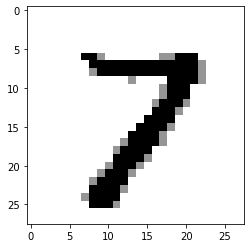

In [3]:
plt.imshow(npzfile['X_test'][34].reshape(28,28), cmap='Greys')
y_test = npzfile['y_test']
print('True label',y_test[34])

You should implement your own Naïve Bayes classifier for classifying the handwritten digits. For that you **must not use any classifier from another toolbox or library**. You should implement the follwoing two functions:
* `NBTrain` for training a Naïve Bayes classifier with a Laplace correction, and
* `NBClassify` for classification.

After implementing the functions you should test your classifier on the test set of handwritten digits. Below you will find a detailed description of the functions you should implement and tests you should perform.

## Task 1: Implement the function `NBTrain()`

The first function is 

    NBTrain(Pat, PatClass, FNum, CNum, LC=0)
    
where 
* `Pat` are training patterns stored in a two-dimensional array of integers with values between 0 and `FNum-1`,
* `PatClass` are true classes of the patterns in the array `Pat`; that is `PatClass[i]` is the true class for the pattern `Pat[i]`,
* `FNum`is the number of possible values for a feature, features can have values between 0 and `FNum-1` only, we assume `FNum` $\le50$,
* `CNum` is the number classes, `PatClass` can contain only values between 0 and `CNum-1` (we assume `CNum` $\le 20$), and
* `LC` is the value of Laplace correction.

Function `NBTrain` should return a pair `(B,P)` of tables:
* `B` is a three-dimensional array, where `B[f,c,i]` is the **logarithm** of the probability that a pattern with value `f` in feature `i` is classified into the class `c`. For computing this conditional probability you should use Laplace correction in the following form 

$$B[f,c,i] = \log\frac{\mbox{the number of pattern with classification } c \mbox{ and value } f \mbox{ in the element } i \mbox{ of the pattern} + LC}{\mbox{the number of patterns from class } c + FNum\cdot LC}$$

*  `P` is an array of log priors - **logarithms** of the estimate s of apriori probabilities for all classes (without the Laplace correction)

$$P[c] = \log \frac{\mbox{the number of patterns classified into class } c}{\mbox{the number of all patterns}}\ .$$

In [4]:
def NBTrain(Pat, PatClass, FNum, CNum, LC=0):
    # your code goes here
    n_pat_fci = []
    for f in range(FNum):
        pat_f = Pat == f
        n_pat_f = []
        for c in range(CNum):
            pat_fc = pat_f[PatClass == c]
            n_pat_f.append(np.sum(pat_fc, axis=0))
        n_pat_fci.append(n_pat_f)
    n_pat_fci = np.array(n_pat_fci)
    print(n_pat_fci.shape)

    n_pat_c = np.bincount(PatClass, minlength=CNum)
    B = np.log((n_pat_fci + LC) / (n_pat_c[np.newaxis, :, np.newaxis] + FNum * LC))

    P = np.log(n_pat_c / len(Pat))       

    return (B, P)      

## Task 2: Implenet the function `NBClassify()`

The second function 

    NBClassify(Pat, B, P)

computes the classification of the patterns `Pat` based on tables `B` and `P` produced by the function `NBTrain` and using the method of Naïve Bayes classifier. Its parameters are
* `Pat` is a two-dimensional array of patterns (each row of `Pat` is one pattern),
* `B` is a three-dimensional array of floats - the first array computed by `NBTrain`, and
* `P` is a vector of floats - the second array computed by `NBTrain`.

The function returns a vector containing predicted classes for all patterns from `Pat`.

In the implementation you shoud use logarithm, as otherwise by computing products of large number of values less than one, the accuracy can be lost.

In [5]:
def NBClassify(Pat, B, P):
    # your code goes here
    pat_len = len(Pat[0])
    FIdx = np.arange(pat_len)
    preds = []
    for p in Pat:
        Bp = B[p, :, FIdx] # [FNum, c]
        Bp = np.sum(Bp, axis=0)
        pred = np.argmax(P + Bp)
        preds.append(pred) 
    return preds

## Task 3: Find the best classifier

1. Calculate the error of the classifier on the training set `X_train` and the test set `X_test` for different values Laplace correction values `LC` = 0, 0.001, 0.01, 0.1, 0.2, 0.4, 1, 10. Present the results in a tabular form. For which of these Laplace correction values is the error on the test set minimal?

3. Describe the errors made by yuor best obtained classifier. This description should include the images of the first 10 handwritten digits on which your best classifier made an error, **together with the required and incorrect classification** of those digits.

In [6]:
X_train, y_train, X_test, y_test = npzfile['X_train'], npzfile['y_train'], npzfile['X_test'], npzfile['y_test']

FNum = np.max(X_train)+1 - np.min(X_train)
CNum = np.max(y_train)+1 - np.min(y_train)

print("="*(10*3+4))
print("|    LC    |  train   |   test   |")
for lc in [0, 0.001, 0.01, 0.1, 0.2, 0.4, 1, 10]:
#for lc in [0]:
    B, P = NBTrain(X_train, y_train, FNum, CNum, LC=lc)
    train_pred = NBClassify(X_train, B, P)
    train_error = np.sum(train_pred == y_train)/len(y_train)
    
    test_pred = NBClassify(X_test, B, P)
    test_error = np.sum(test_pred == y_test)/len(y_test)
    #print("|",lc, ", train_err=", train_error, ", test_err=", test_error)
    print("|{:9.3f} |{:9.4f} |{:9.4f} |". format(lc, train_error, test_error))
print("="*(10*3+4))
    

|    LC    |  train   |   test   |
(3, 10, 784)
<ipython-input-4-0d2f93e307cb>:15: RuntimeWarning: divide by zero encountered in log
  B = np.log((n_pat_fci + LC) / (n_pat_c[np.newaxis, :, np.newaxis] + FNum * LC))
|    0.000 |   0.8410 |   0.8468 |
(3, 10, 784)
|    0.001 |   0.8392 |   0.8485 |
(3, 10, 784)
|    0.010 |   0.8387 |   0.8480 |
(3, 10, 784)
|    0.100 |   0.8380 |   0.8476 |
(3, 10, 784)
|    0.200 |   0.8378 |   0.8476 |
(3, 10, 784)


KeyboardInterrupt: 

## The error on the test set is minimal for Laplace correction equal to **0.001**

0 ; True label: 5 , False label: 4
1 ; True label: 5 , False label: 3
2 ; True label: 6 , False label: 4
3 ; True label: 4 , False label: 0
4 ; True label: 2 , False label: 3
5 ; True label: 1 , False label: 3
6 ; True label: 6 , False label: 2
7 ; True label: 0 , False label: 8
8 ; True label: 3 , False label: 2
9 ; True label: 4 , False label: 9


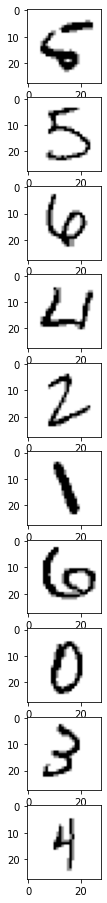

In [85]:

B, P = NBTrain(X_train, y_train, FNum, CNum, LC=0.001)
test_pred = NBClassify(X_test, B, P)
wrong_classif = test_pred != y_test
wc, i = 0, 0
fig = plt.figure(figsize=(5, 16))
while wc < 10:
    if wrong_classif[i]:
        fig.add_subplot(10, 1, wc+1)
        plt.imshow(X_test[i].reshape(28,28), cmap='Greys')
        print(wc, "; True label:", y_test[i], ", False label:", test_pred[i])
        wc += 1
    i += 1
plt.show()


2. As can be seen above, the classifier made many mistakes. Some of mistakes were obvious while with some images would be hard to classify even for a regular person. 

The 0 image does not look like number five at all. 

The image 1 looks like number 5 but the left vertical line is too short and the lower part is too big compared with regular number 5. 

Image 2 is tilted to the left and Bayes classifier is not shift invariant. 

Image 3 also doesn't resemble number 4.

Images 4, 5, and 6 are tilted to the left and I assume that most of the dataset images are not tilted like this.

Image 7 has probably lot of black pixels similar to the average image with label 8.

Image 8 is also slightly tilted with the lower part being too horizontal for it to be classified as number 3 and kind of resembles the base of number 2

Image 9 resembles a lot the number 9 with its small upper part.
